In [1]:
import os
import numpy as np
from PIL import Image
import pandas as pd

import torch
from torchvision import transforms

from gpt_guessr import GPTGuessrConvNeXt

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
        normalize,
    ])

model = GPTGuessrConvNeXt(num_channels=9, num_countries=50)
# print(torch.load("guessr_006.pth/pytorch_model.bin", map_location=torch.device('cpu')).keys())
model.load_state_dict(torch.load("guessr_058.pth", map_location=torch.device('cpu'))['model_state_dict'])
model.eval()

def get_coords():
    items = []
    for i in range(0, 3):
        data_path = f'data/imgs/street_view_000001_{i}.jpg'
        img = Image.open(data_path)
        items.append(img.convert("RGB"))
    
    for i, item in enumerate(items):
        items[i] = preprocess(item)
    
    items = torch.cat((items[0], items[1], items[2]), dim=0).unsqueeze(0)
    print(items.shape)
    print(items.max())
    
    pred_country, pred_coords = model(items)
    return pred_country, pred_coords
    pred_coords = pred_coords.detach().numpy()[0]
    pred_coords = [str(pred_coords[0]), str(pred_coords[1])]
    
    print(torch.argmax(pred_country))
    return pred_coords
    

In [2]:
data_path = f'data/imgs/street_view_000001_{0}.jpg'
img = Image.open(data_path)
img = preprocess(img)
print(img.max())


tensor(2.3960)


In [3]:
from geo_guessr_dataset import GeoGuessrDataset
dataset = GeoGuessrDataset('data/', transform=preprocess, size=512)

In [4]:
img = (dataset[300]['images'][0:3])
print(img.max())
print(img.shape)

tensor(2.6400)
torch.Size([3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


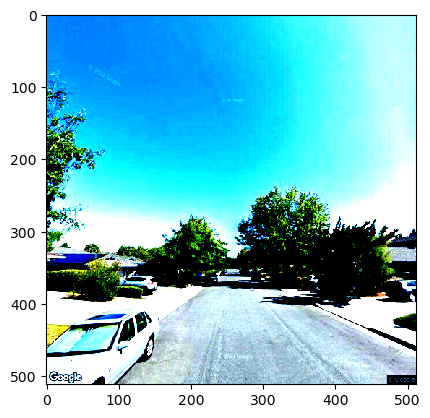

In [5]:
from matplotlib import pyplot as plt
plt.imshow(img.permute(1,2,0), interpolation='nearest')
plt.show()

In [13]:
dataset[8]['images']

torch.Size([9, 512, 512])

In [8]:
df = pd.read_pickle('data/dataset.df')
state_keys = {}
i = 0
for state in sorted(df['state']):
    if state not in state_keys:
        state_keys[state] = i
        i += 1
state_keys = {y: x for x, y in state_keys.items()}

In [9]:
def haversine_distance(coord1, coord2):
    R = 6371.0 # Earth's radius in kilometers
    # coord1, coord2 = coord1.clone().detach(), coord2.clone().detach()
    lat1, lon1 = coord1[..., 0], coord1[..., 1]
    lat2, lon2 = coord2[..., 0], coord2[..., 1]
    phi1, phi2 = torch.deg2rad(lat1), torch.deg2rad(lat2)
    delta_phi = torch.deg2rad(lat2 - lat1)
    delta_lambda = torch.deg2rad(lon2 - lon1)
    
    a = torch.sin(delta_phi / 2.0)**2 + \
        torch.cos(phi1) * torch.cos(phi2) * \
        torch.sin(delta_lambda / 2.0)**2
    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
    distance = R * c
    return distance

In [10]:
idx = 645

with torch.no_grad():
    pred_country, pred_coords = model(dataset[idx]['images'].unsqueeze(0))
print(state_keys[torch.argmax(pred_country).item()])

print(pred_coords)
print(dataset[idx]['coords'])
haversine_distance(pred_coords, dataset[idx]['coords'])

Texas
tensor([[ 11.0255, -26.1230]])
tensor([ 40.8752, -73.3525])


tensor([5672.4131])

In [12]:
print(model)

GPTGuessrConvNeXt(
  (convnext): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(9, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2